In [1]:
import torch

# Local imports
from train import train_model

In [2]:
import sys
print(sys.executable)
print(sys.version)

/opt/miniconda3/bin/python
3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]


In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cpu


In [4]:
args = {
    "use_small_dataset": False,
    "batch_size": 64,
    "stoppage_epochs": 32,
    "max_epochs": 512,
    "seed": 0,
    "data_path": "../data",
    "protein_graph_dir": "../data/protein_graphs",
    "frac_train": 0.8,
    "frac_validation": 0.1,
    "frac_test": 0.1,
    "huber_beta": 0.5,
    "weight_decay": 2e-4,
    "lr": 1e-4,
    "scheduler_patience": 10,
    "scheduler_factor": 0.5,
    "hidden_size": 192,
    "emb_size": 96,
    "num_layers": 4,
    "num_attn_heads": 6,
    "dropout": 0.1,
    "mlp_dropout": 0.2,
    "pooling_dim": 96,
    "mlp_hidden": 192,
    "max_nodes": 72, # Max number of amino acids
    "use_cross": True,
    "model_path": '../models/model1.pth',
    "dataset": "DAVIS" # Choose from CD4C, DAVIS, and KIBA
}

In [ ]:
import argparse

training_args = argparse.Namespace(**args)
train_model(training_args, device)

Model parameters: 3,114,830
Loading DAVIS dataset from cache: ../data/DAVIS_dataset.csv
INFO: Validating protein graph paths...
  Checking for: original_pid='HIPK1', found direct match: ../data/protein_graphs/HIPK1.pt
  Checking for: original_pid='HIPK1', found direct match: ../data/protein_graphs/HIPK1.pt
  Checking for: original_pid='HIPK1', found direct match: ../data/protein_graphs/HIPK1.pt
  Checking for: original_pid='HIPK1', found direct match: ../data/protein_graphs/HIPK1.pt
  Checking for: original_pid='HIPK1', found direct match: ../data/protein_graphs/HIPK1.pt
INFO: Validating protein graph paths...
  Checking for: original_pid='MAST1', found direct match: ../data/protein_graphs/MAST1.pt
  Checking for: original_pid='MAST1', found direct match: ../data/protein_graphs/MAST1.pt
  Checking for: original_pid='MAST1', found direct match: ../data/protein_graphs/MAST1.pt
  Checking for: original_pid='MAST1', found direct match: ../data/protein_graphs/MAST1.pt
  Checking for: origin

Epoch 1/512:   6%|▌         | 18/323 [01:47<24:26,  4.81s/it] 

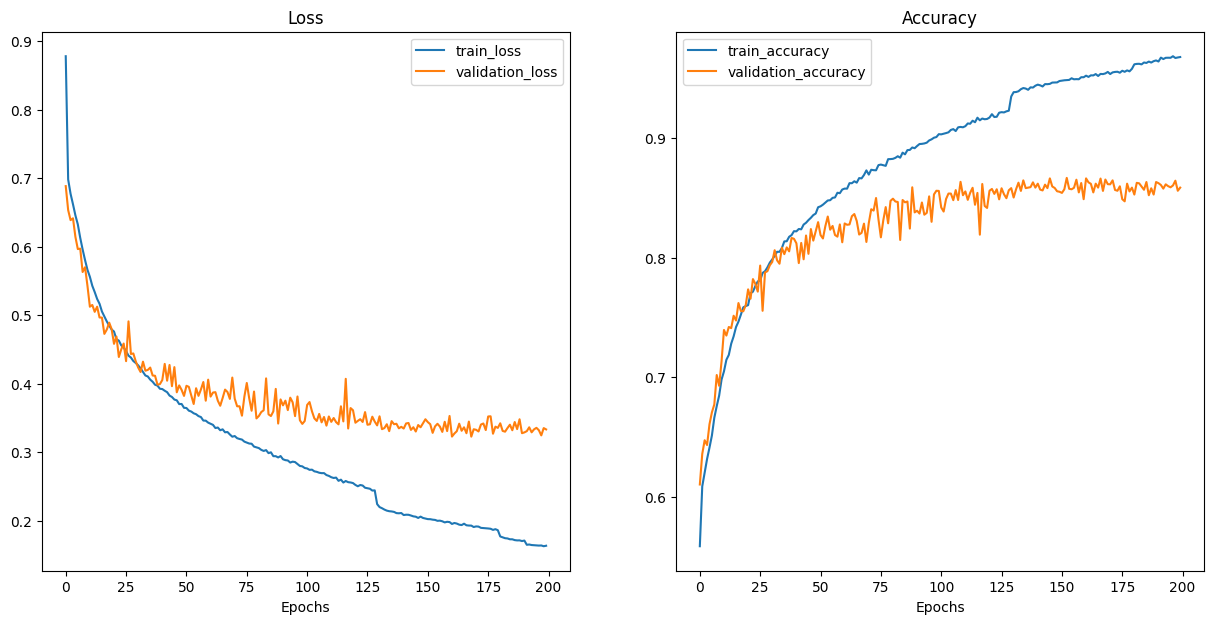

In [ ]:
import pandas as pd

from utils.helper_functions import plot_loss_curves

csv_path = f"{training_args.model_path}.csv"
metrics = pd.read_csv(csv_path) 

plot_loss_curves(metrics)